In [25]:
#import necessary libraries
import numpy as np
import pandas as pd
import os
import glob
import math
import random as rand
import keras
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import f1_score, accuracy_score, hamming_loss, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn import tree, metrics
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GRU
from keras.callbacks import Callback, EarlyStopping
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from tensorflow.keras.layers import LSTM,Conv1D, TimeDistributed, BatchNormalization

In [6]:
def eventroll_to_multihot_vector(eventroll):
    """
    Parameters
    ----------
    eventroll : np.array
        Eventroll matrix of shape=(11, 1000).
    
    Returns
    -------
    np.array
        A multihot vector of shape=(10,)
    """
    
    # findout active events:
    active_events = (eventroll.sum(axis=1) >= 0.5).astype('float')
    
    # remove silence class:
    return np.delete(active_events, 8)


#define functions to measure recall, precision and f1-score
def recall_m(y_true, y_preds):
    true_positives = K.sum(K.round(K.clip(y_true * y_preds, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_preds):
    true_positives = K.sum(K.round(K.clip(y_true * y_preds, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_preds, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_preds):
    precision = precision_m(y_true, y_preds)
    recall = recall_m(y_true, y_preds)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#self-defined new_accuracy measure
def new_accuracy(y_true, y_preds):
    true_positives = K.sum(K.round(K.clip(y_true * y_preds, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    acc = true_positives / (possible_positives + K.epsilon())
    return acc

#logical operators used to calculate accuracy, hamming loss and precision (new definitions)
def alt_Accuracy(y_true, y_pred):
   temp = 0
   for i in range(y_true.shape[0]):
       temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
   return temp / y_true.shape[0]
    
def alt_Hamming_Loss(y_true, y_pred):
    temp=0
    for i in range(y_true.shape[0]):
        temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
    return temp/(y_true.shape[0] * y_true.shape[1])
    
def alt_Precision(y_true, y_pred):
      temp = 0
      for i in range(y_true.shape[0]):
          if sum(y_true[i]) == 0:
              continue
          temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
      return temp/ y_true.shape[0]

In [ ]:
# events_types = {
#     0: 'Alarm_bell_ringing', 
#     1: 'Blender', 
#     2: 'Cat', 
#     3: 'Dishes', 
#     4: 'Dog',
#     5: 'Electric_shaver_toothbrush', 
#     6: 'Frying', 
#     7: 'Running_water', 
#     8: 'Speech', 
#     9: 'Vacuum_cleaner'
# }

reverse_mapping=['Alarm_bell_ringing', 'Blender', 
'Cat', 
'Dishes', 
'Dog',
'Electric_shaver_toothbrush', 
'Frying', 
'Running_water', 
'Speech', 
'Vacuum_cleaner'
                ]
# removed #8=silence class

In [ ]:
labels_dict={0:1499,1:993,2:1128,3:2440,4:1412,5:1096,6:1349,7:1219,8:9201,9:1046}
def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight
class_weights=create_class_weight(labels_dict)
# print(class_weights)

In [12]:
TRAIN_DIR = os.path.join('../input/multilabel2/dataset', 'X/*') 
train = glob.glob(TRAIN_DIR)
max_lengthX=0
tempX={}                                                        #create dict for storing the training npy file data
list_files=[]
for files in train: 
  tempX[files[39:]]=np.load(files) 
  list_files.append(files[39:])
  df = pd.DataFrame(tempX[files[39:]][0])
  if max_lengthX<df.shape[1] :
    max_lengthX=df.shape[1]                                     #calculate maximum length of audio sample, =2584 for train data

print(len(tempX))
print(max_lengthX)
print(len(list_files))


10000
1000
10000


In [ ]:
#used to reduce max_length for using time distributed lstm
for files in train: 
  p,q,r = tempX[files[38:]].shape
  start_padding = rand.randint(0, abs(700 - r))                 #reduce max_length, taken to be 700 here
  end_padding = abs(r - start_padding-700)                      #Randomly slice from left and right to provide better accuracy
  tempX[files[38:]]=(tempX[files[38:]][:,:,start_padding:r-end_padding])
      

In [13]:
EVENTROLL_TRAIN_DIR = os.path.join('../input/multilabel2/dataset', 'Y/*') 
eventroll_train = glob.glob(EVENTROLL_TRAIN_DIR)
max_lengthY=0
tempY={}  
new_Y={}

for files in eventroll_train:
  tempY[files[41:]]=np.load(files) 
  new_Y[files[41:]]=eventroll_to_multihot_vector(tempY[files[41:]])
  df = pd.DataFrame(tempY[files[41:]])
  if max_lengthY<df.shape[1] :
    max_lengthY=df.shape[1]                                     #calculate maximum length of audio sample, =1000 for train data

print(len(tempY))
print(max_lengthY)


10000
1000


In [14]:
train_X=[]
train_Y=[]
for name in list_files:
    train_X.append(tempX[name])
    train_Y.append(new_Y[name])

In [16]:
VALIDATION_DIR = os.path.join('../input/multilabel2/validation/dataset', 'X/*') 
validation = glob.glob(VALIDATION_DIR)
max_lengthX=0
valX={}                                                        #create dict for storing the training npy file data
list_files=[]
for files in validation: 
  valX[files[50:]]=np.load(files) 
  list_files.append(files[50:])
  df = pd.DataFrame(valX[files[50:]][0])
  if max_lengthX<df.shape[1] :
    max_lengthX=df.shape[1]                                     #calculate maximum length of audio sample, =1000 for train data

print(len(valX))
print(max_lengthX)

2000
1000


In [ ]:
#used to reduce max_length for using time distributed lstm
for files in validation: 
  p,q,r = valX[files[49:]].shape
  start_padding = rand.randint(0, abs(700 - r))                 #reduce max_length, taken to be 700 here
  end_padding = abs(r - start_padding-700)                      #Randomly slice from left and right to provide better accuracy
  valX[files[49:]]=(valX[files[49:]][:,:,start_padding:r-end_padding])
      

In [17]:
EVENTROLL_VAL_DIR = os.path.join('../input/multilabel2/validation/dataset', 'Y/*') 
eventroll_validation = glob.glob(EVENTROLL_VAL_DIR)
max_lengthY=0
valY={}                                                        #create dict for storing the training npy file data
new_val_Y={}
for files in eventroll_validation: 
  valY[files[52:]]=np.load(files) 
#   arr[files]=temp[files].copy()
#   print(valY[files].shape)
  new_val_Y[files[52:]]=eventroll_to_multihot_vector(tempY[files[52:]])
  df = pd.DataFrame(valY[files[52:]])
  # df=df.loc[:, (df**2).sum() != 0]
#   print(df.shape)
  if max_lengthY<df.shape[1] :
    max_lengthY=df.shape[1]                                     

print(len(valY))
print(max_lengthY)

2000
1000


In [18]:
val_X=[]
val_Y=[]
for name in list_files:
    val_X.append(valX[name])
    val_Y.append(new_val_Y[name])

In [19]:
train_X=np.stack(train_X)
train_Y=np.stack(train_Y)

val_X=np.stack(val_X)
val_Y=np.stack(val_Y)

In [20]:
train_X=np.transpose(train_X,(0,2,3,1))   
val_X=np.transpose(val_X,(0,2,3,1))         

In [21]:
print(train_X.shape)

(10000, 64, 1000, 1)


In [ ]:
#CNN model(used for assignment 1)
from keras import regularizers
from keras.layers import Bidirectional,GRU, BatchNormalization, LSTM, Reshape
model = Sequential()

model.add(Conv2D(32, 3, activation = 'relu', input_shape = (train_X.shape[1:])))
model.add(Conv2D(64, 3, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Dropout(0.2))
model.add(Conv2D(128, 3, activation = 'relu'))
model.add(Conv2D(256, 3, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m, new_accuracy])
model.summary()

In [22]:
#CNN model with 2 convolution layers, along with batch normalization and 2 dense layers
from keras import regularizers
from keras.layers import Bidirectional,GRU
class model_net:
    def build(width, height, depth, classes):

        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Activation("relu"))
        model.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
        model.add(Dense(10, activation='sigmoid'))

        return model

In [26]:
model = model_net.build(width=1000, height=64,depth=1, classes=10)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), 'accuracy', f1_m, precision_m, recall_m, new_accuracy])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 1000, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 1000, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 1000, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 333, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 333, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 333, 64)       18496     
_________________________________________________________________
activation_2 (Activation)    (None, 21, 333, 64)      

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8) #implement early stopping 
history = model.fit(train_X, train_Y, validation_data=(val_X, val_Y),epochs=10, callbacks=es,class_weight=class_weights)

Epoch 1/10
128/313 [===========>..................] - ETA: 5:56 - loss: 0.2888 - binary_accuracy: 0.8962 - accuracy: 0.1257 - f1_m: 0.7051 - precision_m: 0.9014 - recall_m: 0.5802 - new_accuracy: 0.5802

In [ ]:
#Time Distributed RNN layers along with batch normalization and 2 dense layers
def new_model():
    model=Sequential()
    model.add(BatchNormalization(input_shape=(64,700,1)))
    model.add(TimeDistributed(LSTM(128,activation='relu',return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(128, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(10, activation='sigmoid'))
    print(model.summary())
    return model

modelx=new_model()

In [ ]:
modelx.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.BinaryAccuracy(), 'accuracy', f1_m, precision_m, recall_m,new_accuracy])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8) #implement early stopping 
history = modelx.fit(train_X, train_Y, validation_data=(val_X, val_Y),epochs=5, callbacks=es)

In [82]:
TEST_DIR = os.path.join('../input/multilabelset/test', 'X/*') 
test = glob.glob(TEST_DIR)
max_lengthX=0
tempX={}                                                        #create dict for storing the training npy file data
list_files=[]
for files in test: 
  tempX[files[38:]]=np.load(files) 
  list_files.append(files[38:])
  df = pd.DataFrame(tempX[files[38:]][0])
  if max_lengthX<df.shape[1] :
    max_lengthX=df.shape[1]    
    
# for files in test: 
#   p,q,r = tempX[files[38:]].shape
#   start_padding = rand.randint(0, abs(700 - r))                 #reduce max_length, taken to be 700 here
#   end_padding = abs(r - start_padding-700)                      #Randomly slice from left and right to provide better accuracy
#   tempX[files[38:]]=(tempX[files[38:]][:,:,start_padding:r-end_padding])
      
test_X=[]
# train_Y=[]
for name in list_files:
    test_X.append(tempX[name])
#     train_Y.append(new_Y[name])
test_X=np.stack(test_X)
test_X=np.transpose(test_X,(0,2,3,1))   
print(test_X.shape)

(2500, 64, 1000, 1)


In [88]:
y_preds = model.predict(test_X)
print(y_preds[0],y_preds[1],y_preds[2].shape)


[1.78750187e-01 7.78094828e-02 3.95381749e-02 1.01466805e-01
 1.81836545e-01 7.93129206e-04 9.57141674e-06 3.79745960e-02
 9.54885960e-01 6.34917617e-03] [1.4688462e-02 1.6832888e-02 8.7945164e-06 3.6910480e-01 4.9264431e-03
 5.8542395e-01 6.5637225e-01 1.3539347e-01 9.4922173e-01 2.5260108e-06] (10,)


In [89]:
for i in range(2500):
    for j in range(10):
        if(y_preds[i][j]>0.3):
            y_preds[i][j]=1
        else :
            y_preds[i][j]=0
print(y_preds[0],y_preds[1],y_preds[2].shape)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 0. 1. 1. 0. 1. 0.] (10,)


In [86]:
result=[]
result.append([])
for i in range(2500):
    for j in range(10):
       if y_preds[i][j]==1:
           result[i].append(reverse_mapping[j])
    result.append([])
result.pop()
print(len(result))

2500


In [90]:
from IPython.display import HTML
import pandas as pd
import numpy as np
df1 = pd.DataFrame(result, index=list_files)
df1.to_csv('out.csv', encoding = 'utf-8-sig') 

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='out.csv')

In [ ]:
print(hamming_loss(test_Y, y_preds))
print(classification_report(test_Y, y_preds)) #conv2d
# print("accuracy_score =", accuracy_score(test_Y[0], y_preds[0]))

In [ ]:
print(alt_Accuracy(test_Y, y_preds), alt_Hamming_Loss(test_Y, y_preds), alt_Precision(test_Y, y_preds))

In [ ]:
class_accuracies = []
for classes in np.unique(test_Y):
    class_acc = np.mean(y_preds[test_Y == classes] == classes)
    class_accuracies.append(class_acc)
print(class_accuracies)

In [105]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix

#use other methods on 1d array
nsamples, nx, ny, nz = train_X.shape
new_X_train = train_X.reshape((nsamples,nx*ny*nz))
nsamples, nx, ny, nz = test_X.shape
new_X_test = test_X.reshape((nsamples,nx*ny*nz))
print(new_X_train.shape)

# print(metrics.classification_report(arr1, y_preds, digits=3))

(10000, 64000)


In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(train_X, train_Y)  # apply scaling on training data
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

pipe.score(val_X, val_Y)  # apply scaling on testing data, without leaking training data.

In [ ]:
from sklearn.linear_model import LogisticRegression
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())
# train
classifier.fit(new_X_train, train_Y)

predictions = classifier.predict(new_X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(val_Y,predictions))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

for category in categories:
    # Training logistic regression model on train data
    LogReg_pipeline.fit(train_X,train_Y )
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(val_X)
    print('Test accuracy is {}'.format(accuracy_score(val_Y, prediction)))
    print("\n")

In [ ]:
import sklearn
from sklearn.metrics import classification_report
print(classification_report(val_Y,y_preds))
classwise_cm = sklearn.metrics.multilabel_confusion_matrix(val_Y,y_preds)

df_cm = pd.DataFrame(cm, reverse_mapping, reverse_mapping)
plt.figure(figsize = (16,8))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, )

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

print ("Showing Confusion Matrix")
# y_prob = model.predict_proba(val_X, verbose=0)
y_pred = y_preds.argmax(axis=-1)
y_true = np.argmax(val_Y, 1)
cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, reverse_mapping, reverse_mapping)
plt.figure(figsize = (16,8))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, )

In [ ]:
#create decision tree classifier
DTmodel = tree.DecisionTreeClassifier()
DTmodel=DTmodel.fit(new_X_train, train_Y)
y_preds = DTmodel.predict(new_X_test)
print(accuracy_score(val_Y, y_preds))
# print(metrics.classification_report(val_Y, y_preds, digits=3))
# cm= confusion_matrix(arr1[:,9], y_preds[:,9]) 
# print(cm) 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(val_Y,y_preds))

In [ ]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(new_X_train, train_Y)

# predict
predictions = classifier.predict(new_X_test)
accuracy_score(val_Y,predictions)

In [ ]:
print(classification_report(test_Y,predictions))

In [58]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
plot_metric(modelx, 'accuracy')

TypeError: 'Sequential' object is not subscriptable

../input/multilabel2/dataset/X/melspec_9060.npy


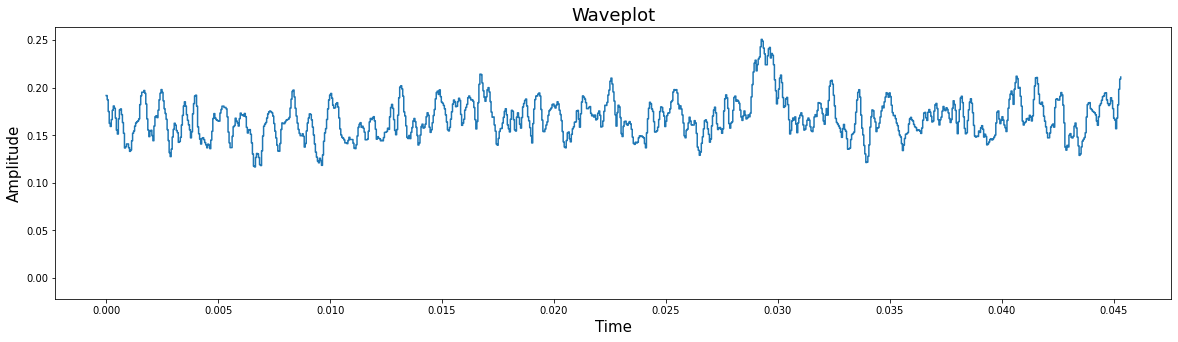

../input/multilabel2/dataset/X/melspec_349.npy


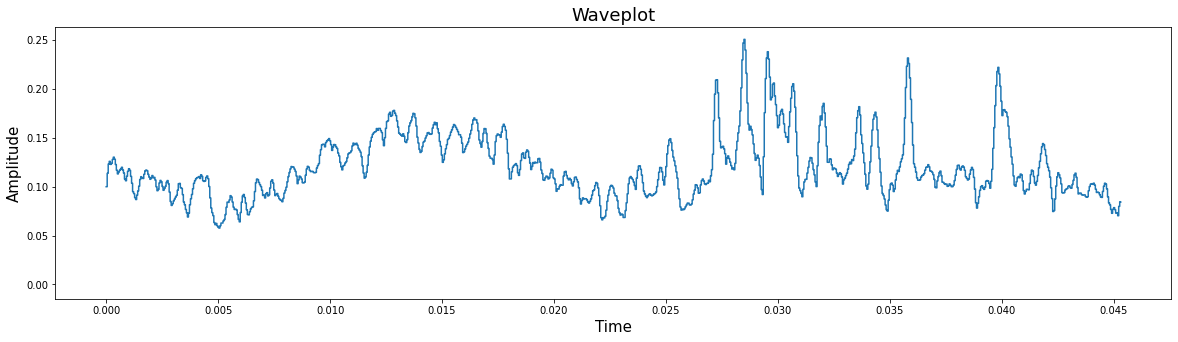

../input/multilabel2/dataset/X/melspec_5524.npy


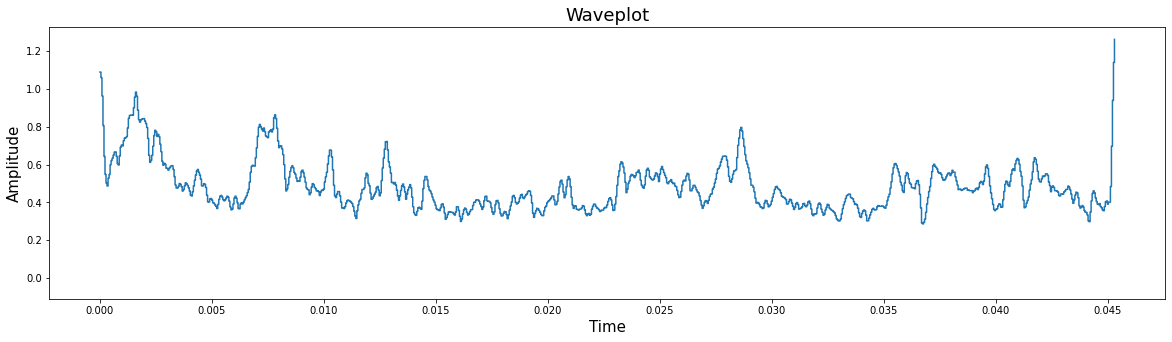

In [54]:
import librosa
import librosa.display
TRAIN_DIR = os.path.join('../input/multilabel2/dataset', 'X/*') 
trainF = glob.glob(TRAIN_DIR)
for files in trainF[:3]:
  print(files)
  files=np.load(files)
  plt.figure(figsize=(20, 5))
  librosa.display.waveshow(files[0], sr=22050)
  plt.title('Waveplot', fontdict=dict(size=18))
  plt.xlabel('Time', fontdict=dict(size=15))
  plt.ylabel('Amplitude', fontdict=dict(size=15))
  plt.show()
#   break

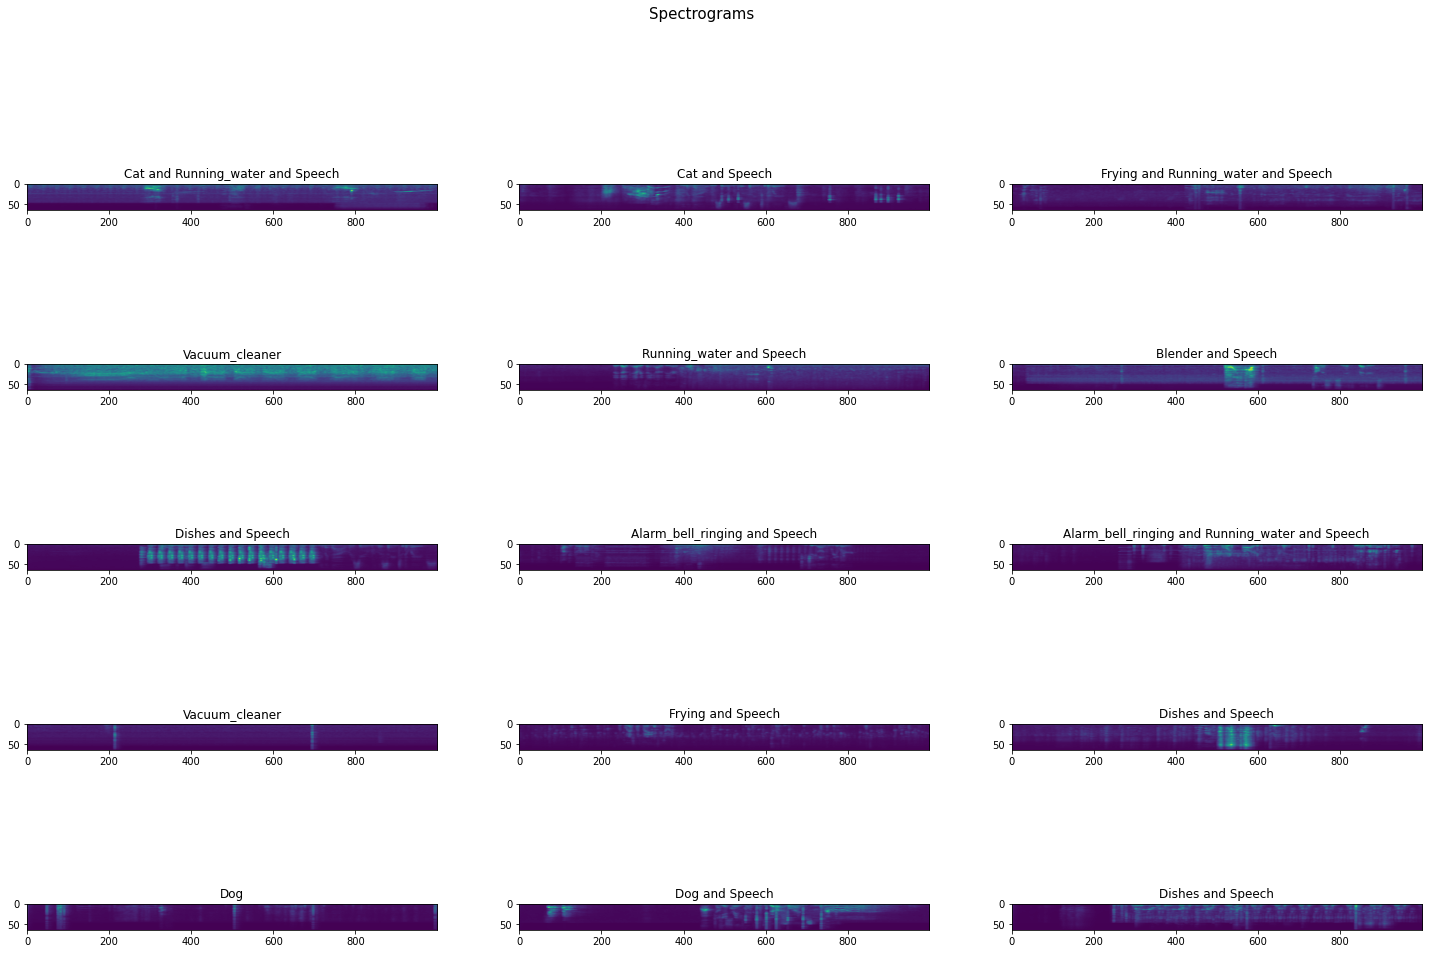

In [52]:
def plot_spectrogram(titles, audio, title, shape=(20,10)):
    r, c = 5, 3
    fig, ax = plt.subplots(r, c, figsize=shape)
    fig.suptitle(title, size=15)
    plt.set_cmap('viridis')
    z = 0
    for i in range(r):
        for y in range(c):
            ax[i,y].set_title(titles[z])
            ax[i,y].imshow(audio[z].squeeze()) #need to squeeze out first dimension to plot images 
            z += 1 
    plt.show()
    
titles = []
audio = []

for i in range(100,115):
    s=""
    ind= np.where(train_Y[i] == 1)[0]
    for num in ind:
        s+=reverse_mapping[num]
        s+=" and "
    s= s[:-5]
    titles.append(s)
    temp= train_X
    audio.append(train_X[i])
plot_spectrogram(titles, audio, title='Spectrograms', shape=(25,16))

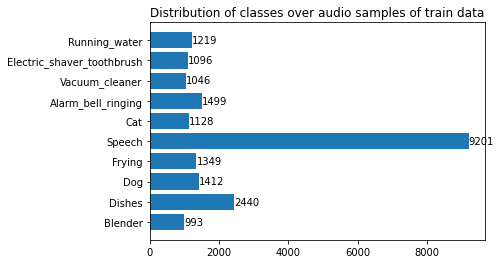

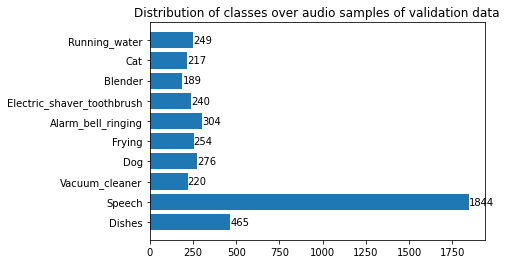

In [109]:
def extract_distribution(X,y,str): #Prints the distribution of classes over audio samples
    tags={}
    for i in range(X.shape[0]):
        ind= np.where(y[i] == 1)[0]
        for j in ind:
            tags[reverse_mapping[j]]= tags.get(reverse_mapping[j], 0)+1

    courses = list(tags.keys())
    values = list(tags.values())
    fig, ax = plt.subplots()
    bars = ax.barh(courses, values)

    ax.bar_label(bars)
    plt.title("Distribution of classes over audio samples of " + str + " data" )
    plt.show()
    
print("\n")
extract_distribution(train_X,train_Y,"train")
print("\n\n")
extract_distribution(val_X,val_Y,"validation")

# extract_distribution(test_X,y_preds,"test")